# Development of SNAP for Ni

## 1. Data loading, Feature analysis and ML model training

### 1.1 Import necessary packages

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from monty.serialization import loadfn
from maml.utils import pool_from, convert_docs

# local environment descriptors imports
from maml.describers import BispectrumCoefficients
from sklearn.decomposition import PCA

# machine learning interatomic potentials imports
from maml.base import SKLModel
from maml.apps.pes import SNAPotential
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# materials properties prediction imports
from pymatgen.core import Structure, Lattice
from maml.apps.pes import LatticeConstant, ElasticConstant, NudgedElasticBand, DefectFormation

# disable logging information
import logging
logging.disable(logging.CRITICAL)

### 1.2 Load DFT data

loadfn - loads json directly from a filename instead of a file-like object

In [2]:
Ni_train_data = loadfn('../data/Ni/training.json')
Ni_test_data = loadfn('../data/Ni/test.json')
print(' # of Ni training data: {}\n'.format(len(Ni_train_data)),
      '# of Ni test data: {}\n'.format(len(Ni_test_data)))

 # of Ni training data: 263
 # of Ni test data: 31



### 1.3 Bispectrum coefficients features

Transform each atom in structures to one array of feature, set pot_fit = False

Bispectrum coefficients used to describe the local environment of each atom. Lammps is required to perform this computation.

In [4]:
element_profile = {'Ni': {'r': 0.5, 'w': 1.0}}
per_atom_describer = BispectrumCoefficients(rcutfac=4.1, twojmax=8, 
                                                 element_profile=element_profile, 
                                                 quadratic=False, 
                                                 pot_fit=False, 
                                                 include_stress=False)

Ni_train_structures = [d['structure'] for d in Ni_train_data]
per_atom_features = per_atom_describer.transform(Ni_train_structures)

print("Total # of atoms in Ni train: {}\n".format(sum([len(struct) for struct in Ni_train_structures])), 
      "     # of features generated: {} (one feature per atom)\n".format(per_atom_features.shape[0]),
      "     # of dimensions: {} (for twojmax = 8)".format(per_atom_features.shape[1]))

per_atom_features

Total # of atoms in Ni train: 27420
      # of features generated: 27420 (one feature per atom)
      # of dimensions: 55 (for twojmax = 8)


0-0-0    1-0-1     1-1-2    2-0-2    2-1-3     2-2-2  \
input_index                                                               
0           0    139.513  3.93944  0.492523  6.07240 -2.48915  0.700852   
            1    146.415  2.76867  0.319388  3.06599 -1.54467  0.163746   
            2    149.665  2.47523  0.168848  2.77639 -1.27165  0.178357   
            3    153.706  2.95881  0.267891  2.94727 -1.45843  0.161124   
            4    171.128  3.16282  0.156948  2.78781 -1.25021  0.171318   
...                  ...      ...       ...      ...      ...       ...   
262         103  153.958  3.10098  0.343818  2.52347 -1.58600  0.186525   
            104  153.958  3.10098  0.343818  2.52347 -1.58600  0.186525   
            105  153.957  3.10105  0.343834  2.52360 -1.58606  0.186539   
            106  153.958  3.10098  0.343818  2.52347 -1.58600  0.186525   
            107  153.958  3.10098  0.343818  2.52347 -1.58600  0.186525   

                    2-2-4    3-0-3    3-1-4    3-2-3  ...    7-3-8    7-4-7  \
input_index                                           ...                     
0           0    1.455720  70.5863 -4.45574  7.12670  ...  20.5418  10.3159   
            1    0.787293  74.7204 -4.81265  5.64023  ...  18.8729  13.2217   
            2    0.583841  72.3612 -4.35138  4.69359  ...  18.6129  13.5242   
            3    0.781879  72.5886 -4.74506  5.02496  ...  19.2241  14.3815   
            4    0.476766  71.7963 -4.98290  3.98774  ...  16.9143  17.2441   
...                   ...      ...      ...      ...  ...      ...      ...   
262         103  0.846944  74.2342 -5.40113  5.48708  ...  16.4479  14.1362   
            104  0.846944  74.2342 -5.40113  5.48708  ...  16.4479  14.1362   
            105  0.846981  74.2340 -5.40114  5.48723  ...  16.4479  14.1359   
            106  0.846944  74.2342 -5.40113  5.48708  ...  16.4479  14.1362   
            107  0.846944  74.2342 -5.40113  5.48708  ...  16.4479  14.1362   

                   7-5-8    7-6-7    7-7-8    8-0-8     8-2-8     8-4-8  \
input_index                                                               
0           0    9.66922  30.3641  10.2673  87.6537  2.256100  2.669480   
            1    5.08479  40.5986  10.8013  67.3526 -0.379105  1.210700   
            2    8.50424  38.7832  12.7083  79.9304  0.629795  3.850270   
            3    6.43559  39.4289  13.9886  79.3138  0.295468  3.471250   
            4    7.88385  39.5565  17.7559  86.8443  0.346483  5.366870   
...                  ...      ...      ...      ...       ...       ...   
262         103  3.61439  45.7346  10.1629  58.2750 -0.943706  0.805015   
            104  3.61439  45.7346  10.1629  58.2750 -0.943706  0.805015   
            105  3.61443  45.7343  10.1625  58.2749 -0.943703  0.804884   
            106  3.61439  45.7346  10.1629  58.2750 -0.943706  0.805015   
            107  3.61439  45.7346  10.1629  58.2750 -0.943706  0.805015   

                    8-6-8     8-8-8  
input_index                          
0           0    4.529910  11.27710  
            1    0.062846   8.32367  
            2    2.775590   9.66870  
            3    2.947910   8.62662  
            4    2.295690   9.82264  
...                   ...       ...  
262         103 -3.780060   9.05611  
            104 -3.780060   9.05611  
            105 -3.780030   9.05621  
            106 -3.780060   9.05611  
            107 -3.780060   9.05611  

[27420 rows x 55 columns]

Transform each structure to one feature for structure and one feature for each atomic force component, set **pot_fit = True**

The dimension of features is 31 instead of 30. There is one extra intercept term at the beginning of the feature. This term is disminished for forces as the intercept disappears in the derivative of the energy.

In [5]:
element_profile = {'Ni': {'r': 0.5, 'w': 1.0}}
per_force_describer = BispectrumCoefficients(rcutfac=4.1, twojmax=8, 
                                                 element_profile=element_profile, 
                                                 quadratic=False, 
                                                 pot_fit=True, 
                                                 include_stress=False)

Ni_train_structures = [d['structure'] for d in Ni_train_data]
per_force_features = per_force_describer.transform(Ni_train_structures)

print("Total # of features expected in Ni: {}\n".format(sum([(1 + 3 * len(struct)) for struct in Ni_train_structures])), 
      "     # of features generated: {} (1+3n features for n-atom structure)\n".format(per_force_features.shape[0]),
      "     # of dimensions: {}".format(per_force_features.shape[1]))

per_force_features

Total # of features expected in Ni: 82523
      # of features generated: 82523 (1+3n features for n-atom structure)
      # of dimensions: 56


Ni                                                       \
                     n       0-0-0     1-0-1     1-1-2      2-0-2     2-1-3   
input_index                                                                   
0           0      1.0  149.657262  2.894600  0.262051   3.808976 -1.489206   
            0_x    0.0   15.642000 -0.876564 -0.092382   3.200620  0.245595   
            0_y    0.0   23.804100  1.983260  2.478140 -14.604700 -3.140660   
            0_z    0.0  -34.468200 -2.568700 -0.730132  -6.027390  0.908478   
            1_x    0.0   15.474900  1.485820 -0.123438  -1.593790  0.049332   
...                ...         ...       ...       ...        ...       ...   
262         106_y  0.0   -0.000618 -0.000172  0.000042  -0.000387  0.000041   
            106_z  0.0    0.000618  0.000172 -0.000042   0.000387 -0.000041   
            107_x  0.0    0.000618  0.000172 -0.000042   0.000387 -0.000041   
            107_y  0.0   -0.000618 -0.000172  0.000042  -0.000387  0.000041   
            107_z  0.0   -0.000618 -0.000172  0.000042  -0.000387  0.000041   

                                                             ...             \
                      2-2-2     2-2-4      3-0-3      3-1-4  ...      7-3-8   
input_index                                                  ...              
0           0      0.216232  0.807394  70.510753  -4.542112  ...  18.593991   
            0_x    0.656399  0.200659   3.617350   0.426499  ... -17.621200   
            0_y   -0.489195 -0.457380  61.551600 -10.680100  ... -15.902600   
            0_z   -2.725930  0.169955   3.997140   1.144500  ...  -1.548660   
            1_x   -0.033147 -0.113679   6.590150  -0.145764  ...  -6.847070   
...                     ...       ...        ...        ...  ...        ...   
262         106_y -0.000075 -0.000021   0.000979  -0.000541  ...  -0.000843   
            106_z  0.000075  0.000021  -0.000979   0.000541  ...   0.000843   
            107_x  0.000075  0.000021  -0.000979   0.000541  ...   0.000843   
            107_y -0.000075 -0.000021   0.000979  -0.000541  ...  -0.000843   
            107_z -0.000075 -0.000021   0.000979  -0.000541  ...  -0.000843   

                                                                           \
                       7-4-7      7-5-8      7-6-7      7-7-8       8-0-8   
input_index                                                                 
0           0      14.095908   7.117876  37.614428  13.279927   78.978630   
            0_x    10.761700 -20.106500  35.615400 -10.532800 -116.648000   
            0_y   -11.961500 -41.655900  90.107900 -68.703200 -253.553000   
            0_z    -1.510620   0.144954  29.707400  12.397500  -37.128200   
            1_x     2.114330  -3.800170   8.289650   2.270190  -38.243100   
...                      ...        ...        ...        ...         ...   
262         106_y  -0.000098  -0.001869   0.002962  -0.001730   -0.010082   
            106_z   0.000098   0.001869  -0.002962   0.001730    0.010082   
            107_x   0.000098   0.001869  -0.002962   0.001730    0.010082   
            107_y  -0.000098  -0.001869   0.002962  -0.001730   -0.010082   
            107_z  -0.000098  -0.001869   0.002962  -0.001730   -0.010082   

                                                               
                       8-2-8      8-4-8      8-6-8      8-8-8  
input_index                                                    
0           0       0.520110   3.723443   2.587382   9.631222  
            0_x    -5.852150 -17.906500 -25.566000 -20.748500  
            0_y   -22.149600 -47.253000 -62.255500 -13.191500  
            0_z    -5.106190  -1.988270 -17.797400   7.563080  
            1_x     0.156108  -1.517150  -7.348440  -8.330890  
...                      ...        ...        ...        ...  
262         106_y  -0.000844  -0.001824  -0.003375  -0.000474  
            106_z   0.000844   0.001824   0.003375   0.000474  
            107_x   0.0

### 1.4 Using PCA to visualize feature space

A reasonable set of structures for potential fitting tends to provide a good coverage of the feature space. However, 
distribution of features with 30 dimensions is impossible to visualize. We need to reduce the dimensions while maintaining most of the information. [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is one of the most important dimension reduction algorithms. PCA keeps the first two principal components which maximize the variances (information) between the features.

transform - transforms a list of objects to one or a list of pandas data frame/numpy ndarray

In [6]:
# Obtain structures from each categories
Ni_train_structures = [d['structure'] for d in Ni_train_data]
Ni_test_structures = [d['structure'] for d in Ni_test_data]

# Obtain the features from each categories
Ni_train_features = per_atom_describer.transform(Ni_train_structures)
Ni_test_features = per_atom_describer.transform(Ni_test_structures)

# Add up features
total_Ni_features = np.concatenate((Ni_train_features, Ni_test_features), axis=0)

# Fit the PCA
pca = PCA(n_components=2)
pca.fit(total_Ni_features)

Ni_train_pcs = pca.transform(Ni_train_features)
Ni_train_pc1 = Ni_train_pcs[:, 0]
Ni_train_pc2 = Ni_train_pcs[:, 1]

Ni_test_pcs = pca.transform(Ni_test_features)
Ni_test_pc1 = Ni_test_pcs[:, 0]
Ni_test_pc2 = Ni_test_pcs[:, 1]

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Visualization of PCA : x axis is the first principal component (PC1) and y axis is the second principal component (PC2).

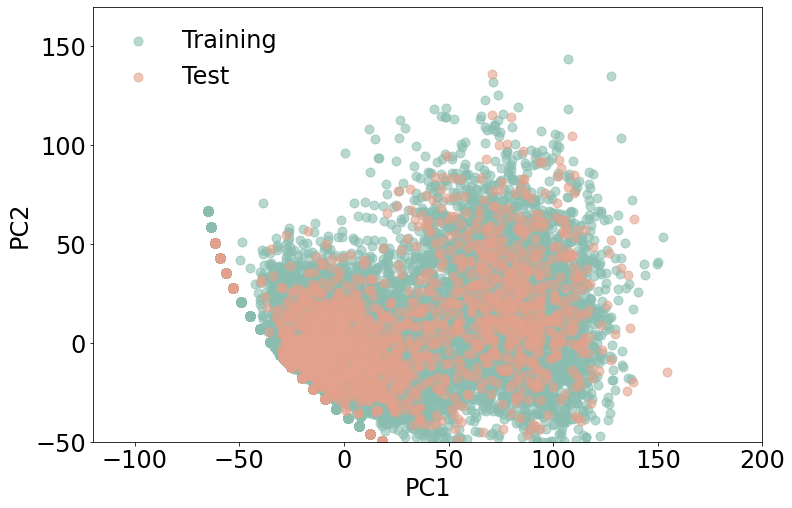

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(Ni_train_pc1, Ni_train_pc2, c='#8ABDB0', alpha=0.6, s=80, label='Training')
ax.scatter(Ni_test_pc1, Ni_test_pc2, c='#E2A18C', alpha=0.6, s=80, label='Test')

from matplotlib import ticker

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

plt.legend(fontsize=24, frameon=False)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('PC1', fontsize=24)
plt.ylabel('PC2', fontsize=24)
plt.xlim(-120, 200)
plt.ylim(-50, 170)

plt.savefig('images/Ni_pca.png', bbox_inches='tight')

### 1.5 Use the DFT-computed energy and forces as targets and train linear regression model

Split the dataset into three lists:
 - list of structure objects [Structure object for each structure]
 - list of energies [total_energy for each structure], 
 - list of forces [n x 3 forces array for each n-atom structure], n can be different for different structures.

In [9]:
Ni_train_structures = [d['structure'] for d in Ni_train_data]
Ni_train_energies = [d['outputs']['energy'] for d in Ni_train_data]
Ni_train_forces = [d['outputs']['forces'] for d in Ni_train_data]

print(" # of structures in Ni data: {}\n".format(len(Ni_train_structures)),
      "# of energies in Ni data: {}\n".format(len(Ni_train_energies)),
      "# of forces in Ni data: {}\n".format(len(Ni_train_forces)),
      "first item in energies: {}\n".format(Ni_train_energies[0]),
      "first item in forces: (n x 3 array)\n", np.array(Ni_train_forces[0]))

 # of structures in Ni data: 263
 # of energies in Ni data: 263
 # of forces in Ni data: 263
 first item in energies: -604.26225029
 first item in forces: (n x 3 array)
 [[-1.92817800e-01 -1.87931786e+00 -6.63740070e-01]
 [-8.25427000e-03 -2.03128550e-01  3.68077660e-01]
 [-5.53716720e-01 -1.47358365e+00  1.29967113e+00]
 [ 4.56780510e-01  5.11745280e-01 -1.09335500e+00]
 [-1.64986311e+00 -1.62587796e+00  4.52548370e-01]
 [-1.66981480e-01  6.80801280e-01  6.77494930e-01]
 [ 3.68023700e-02 -3.14225147e+00 -2.01655837e+00]
 [-1.07304730e-01 -3.57799090e-01  1.13566345e+00]
 [-1.91318200e-01  5.13805880e-01  3.42962310e-01]
 [ 2.00903240e+00  1.51425104e+00 -3.55779620e-01]
 [-1.71281490e-01 -2.78076851e+00 -1.42146099e+00]
 [-9.39866940e-01 -1.67565400e-02  7.93215500e-01]
 [ 3.71903340e-01 -9.06270690e-01 -5.29332790e-01]
 [ 5.64577160e-01 -9.68333350e-01 -7.00431290e-01]
 [-4.57555600e-01 -6.58680900e-02 -3.70377520e-01]
 [-1.20439791e+00  6.39793310e-01  7.50355980e-01]
 [-1.57433846e

Let's use the features with pot_fit = True, i.e., 1+3n features for n-atom structure

In [10]:
Ni_features = per_force_features
print("# of features generated: {}".format(Ni_features.shape[0]))
Ni_features

# of features generated: 82523


Ni                                                       \
                     n       0-0-0     1-0-1     1-1-2      2-0-2     2-1-3   
input_index                                                                   
0           0      1.0  149.657262  2.894600  0.262051   3.808976 -1.489206   
            0_x    0.0   15.642000 -0.876564 -0.092382   3.200620  0.245595   
            0_y    0.0   23.804100  1.983260  2.478140 -14.604700 -3.140660   
            0_z    0.0  -34.468200 -2.568700 -0.730132  -6.027390  0.908478   
            1_x    0.0   15.474900  1.485820 -0.123438  -1.593790  0.049332   
...                ...         ...       ...       ...        ...       ...   
262         106_y  0.0   -0.000618 -0.000172  0.000042  -0.000387  0.000041   
            106_z  0.0    0.000618  0.000172 -0.000042   0.000387 -0.000041   
            107_x  0.0    0.000618  0.000172 -0.000042   0.000387 -0.000041   
            107_y  0.0   -0.000618 -0.000172  0.000042  -0.000387  0.000041   
            107_z  0.0   -0.000618 -0.000172  0.000042  -0.000387  0.000041   

                                                             ...             \
                      2-2-2     2-2-4      3-0-3      3-1-4  ...      7-3-8   
input_index                                                  ...              
0           0      0.216232  0.807394  70.510753  -4.542112  ...  18.593991   
            0_x    0.656399  0.200659   3.617350   0.426499  ... -17.621200   
            0_y   -0.489195 -0.457380  61.551600 -10.680100  ... -15.902600   
            0_z   -2.725930  0.169955   3.997140   1.144500  ...  -1.548660   
            1_x   -0.033147 -0.113679   6.590150  -0.145764  ...  -6.847070   
...                     ...       ...        ...        ...  ...        ...   
262         106_y -0.000075 -0.000021   0.000979  -0.000541  ...  -0.000843   
            106_z  0.000075  0.000021  -0.000979   0.000541  ...   0.000843   
            107_x  0.000075  0.000021  -0.000979   0.000541  ...   0.000843   
            107_y -0.000075 -0.000021   0.000979  -0.000541  ...  -0.000843   
            107_z -0.000075 -0.000021   0.000979  -0.000541  ...  -0.000843   

                                                                           \
                       7-4-7      7-5-8      7-6-7      7-7-8       8-0-8   
input_index                                                                 
0           0      14.095908   7.117876  37.614428  13.279927   78.978630   
            0_x    10.761700 -20.106500  35.615400 -10.532800 -116.648000   
            0_y   -11.961500 -41.655900  90.107900 -68.703200 -253.553000   
            0_z    -1.510620   0.144954  29.707400  12.397500  -37.128200   
            1_x     2.114330  -3.800170   8.289650   2.270190  -38.243100   
...                      ...        ...        ...        ...         ...   
262         106_y  -0.000098  -0.001869   0.002962  -0.001730   -0.010082   
            106_z   0.000098   0.001869  -0.002962   0.001730    0.010082   
            107_x   0.000098   0.001869  -0.002962   0.001730    0.010082   
            107_y  -0.000098  -0.001869   0.002962  -0.001730   -0.010082   
            107_z  -0.000098  -0.001869   0.002962  -0.001730   -0.010082   

                                                               
                       8-2-8      8-4-8      8-6-8      8-8-8  
input_index                                                    
0           0       0.520110   3.723443   2.587382   9.631222  
            0_x    -5.852150 -17.906500 -25.566000 -20.748500  
            0_y   -22.149600 -47.253000 -62.255500 -13.191500  
            0_z    -5.106190  -1.988270 -17.797400   7.563080  
            1_x     0.156108  -1.517150  -7.348440  -8.330890  
...                      ...        ...        ...        ...  
262         106_y  -0.000844  -0.001824  -0.003375  -0.000474  
            106_z   0.000844   0.001824   0.003375   0.000474  
            107_x   0.0

pool_from - Method to convert structures and their properties in to datapool format; ([dict]) returned

convert_docs - http://maml.ai/maml.utils.html?highlight=convert_docs#maml.utils.convert_docs

In [11]:
Ni_train_pool = pool_from(Ni_train_structures, Ni_train_energies, Ni_train_forces)
_, Ni_df = convert_docs(Ni_train_pool)
print("# of targets: ", len(Ni_df))
Ni_df

# of targets:  82523


,y_orig,n,dtype
0,-604.262250,107.0,energy
1,-0.192818,1.0,force
2,-1.879318,1.0,force
3,-0.663740,1.0,force
4,-0.008254,1.0,force
...,...,...,...
82518,0.000000,1.0,force
82519,0.000000,1.0,force
82520,0.000000,1.0,force
82521,-0.000000,1.0,force


Create targets per atom (energy per atom = total_energies / num_atoms, force components per atom = $f_{x}$, $f_{y}$, $f_{z}$.

Use sklearn LinearRegression model to fit the features and targets, both simple linear model and weighted linear model are obtained

In [12]:
##### Simple Linear regression
y = Ni_df['y_orig']/Ni_df['n']  
x = Ni_features

simple_model = LinearRegression()
simple_model.fit(x, y)

##### Increase the weights of energies since the number of forces are overwhelming
weights = np.ones(len(Ni_df['dtype']), )
weights[Ni_df['dtype'] == 'energy'] = 10000
weights[Ni_df['dtype'] == 'force'] = 1

weighted_model = LinearRegression()
weighted_model.fit(x, y, sample_weight=weights)

print("# of parameters in simple linear model: {}\n".format(len(simple_model.coef_)), 
      "parameters in simple linear model: \n", simple_model.coef_, "\n")
print("# of parameters in weighted linear model: {}\n".format(len(weighted_model.coef_)), 
      "parameters in weighted linear model: \n", weighted_model.coef_)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


# of parameters in simple linear model: 56
 parameters in simple linear model: 
 [-1.48625374e+01  1.79985357e-02 -3.86739747e-03  1.33231300e-01
 -9.66015460e-03  2.68267378e-01  9.93542465e-02  1.26766774e-01
  9.17446771e-03  1.35605224e-01  1.50143403e-01  1.48343750e-01
  7.30649083e-02  2.71932324e-02  3.70649156e-03  1.07332931e-01
  6.29895699e-02  1.08096312e-01  9.57247372e-02  2.55683849e-02
  2.50490838e-02  3.44105309e-02  3.15090714e-03 -2.32720130e-03
  7.06840478e-02  5.14776429e-02  5.75731076e-02  6.18193135e-02
  6.35833431e-04  3.45375944e-02  3.04773111e-02  1.60671043e-02
  4.40183534e-03 -7.69197673e-03  3.70736613e-02  4.23868521e-02
  2.41072781e-02  3.59948756e-02  1.53255635e-02  8.79962938e-03
  1.24873382e-02  4.68461692e-03  4.12320709e-03 -4.93674155e-03
  1.35228210e-02  1.89280677e-02  1.14238921e-02  2.04018796e-03
  7.45664032e-04  4.38066315e-03  1.30052641e-03 -9.24104995e-04
  3.46242259e-03 -5.36413567e-04 -1.92068214e-03  8.02345494e-04] 

# of p

Predict the energy and forces using fitted machine learning models, get the errors of energies and forces

In [14]:
energy_indices = np.argwhere(np.array(Ni_df["dtype"]) == "energy").ravel()
forces_indices = np.argwhere(np.array(Ni_df["dtype"]) == "force").ravel()

simple_predict_y = simple_model.predict(x)
weighted_predict_y = weighted_model.predict(x)

original_energy = y[energy_indices]
original_forces = y[forces_indices]
simple_predict_energy = simple_predict_y[energy_indices]
simple_predict_forces = simple_predict_y[forces_indices]
weighted_predict_energy = weighted_predict_y[energy_indices]
weighted_predict_forces = weighted_predict_y[forces_indices]

print(" Simple model energy MAE: {:.3f} meV/atom\n".format(mean_absolute_error(original_energy, simple_predict_energy) * 1000),
      "Simple model forces MAE: {:.3f} eV/Å\n".format(mean_absolute_error(original_forces, simple_predict_forces)),
      "Weighted model energy MAE: {:.3f} meV/atom\n".format(mean_absolute_error(original_energy, weighted_predict_energy) * 1000),
      "Weighted model forces MAE: {:.3f} eV/Å\n".format(mean_absolute_error(original_forces, weighted_predict_forces)),)

 Simple model energy MAE: 3.117 meV/atom
 Simple model forces MAE: 0.031 eV/Å
 Weighted model energy MAE: 1.170 meV/atom
 Weighted model forces MAE: 0.031 eV/Å



/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


## 2. Potential development & Materials Property Predictions

### 2.1 SNAP Potential development  

Wrap the bispectrum coefficients describer and linear regression model together. These are two inputs for the [SNAPotential](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_snap.py) object from maml package. Use the train() method of the SNAPotential. Three lists of respective structures, energies, and forces array are inputs for the train() method.

In [15]:
# Three lists of structures, energies, and forces array.
Ni_train_structures = [d['structure'] for d in Ni_train_data]
Ni_train_energies = [d['outputs']['energy'] for d in Ni_train_data]
Ni_train_forces = [d['outputs']['forces'] for d in Ni_train_data]
Ni_group = []
for i in range(len(Ni_train_data)):
    Ni_group.append(Ni_train_data[i]['group'])
Ni_num_atoms = [d['num_atoms'] for d in Ni_train_data]
Ni_groups = []
for i in range(len(Ni_train_data)): 
    Ni_groups = Ni_groups + [Ni_group[i]]*(1 + 3*Ni_num_atoms[i])

# Set the external weights.
Ni_train_pool = pool_from(Ni_train_structures, Ni_train_energies, Ni_train_forces)
_, Ni_df = convert_docs(Ni_train_pool)
Ni_df["group"] = Ni_groups
weights = np.ones(len(Ni_df['dtype']), )
weights[(Ni_df["dtype"] == "energy") & (Ni_df["group"] == "Elastic")] = 9703.497
weights[(Ni_df["dtype"] == "force") & (Ni_df["group"] == "Elastic")] =  4.357
weights[(Ni_df["dtype"] == "energy") & (Ni_df["group"] == "Surface")] = 2164.024
weights[(Ni_df["dtype"] == "force") & (Ni_df["group"] == "Surface")] =  89.207
weights[(Ni_df["dtype"] == "energy") & (Ni_df["group"] == "AIMD-NVT")] = 8870.845
weights[(Ni_df["dtype"] == "force") & (Ni_df["group"] == "AIMD-NVT")] =  22.822
weights[(Ni_df["dtype"] == "energy") & (Ni_df["group"] == "Vacancy")] =  780.361
weights[(Ni_df["dtype"] == "force") & (Ni_df["group"] == "Vacancy")] =   45.451

# Initialize the bispectrum coefficients describer and linear regression model
element_profile = {'Ni': {'r': 0.5, 'w': 1.0}}
describer = BispectrumCoefficients(rcutfac=4.1, twojmax=8, 
                                   element_profile=element_profile, quadratic=False, 
                                   pot_fit=True, include_stress=False)
ml_model = LinearRegression()
skl_model = SKLModel(describer=describer, model=ml_model)
Ni_snap = SNAPotential(model=skl_model)

# Train the potential with lists of structures, energies, forces
Ni_snap.train(Ni_train_structures, Ni_train_energies, Ni_train_forces, sample_weight=weights)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


### 2.2 Evaluate the energy and forces prediction

Use the fitted snap to evaluate energy and forces errors. 

In [17]:
Ni_test_structures = [d['structure'] for d in Ni_test_data]
Ni_test_energies = [d['outputs']['energy'] for d in Ni_test_data]
Ni_test_forces = [d['outputs']['forces'] for d in Ni_test_data]

df_orig, df_predict = Ni_snap.evaluate(test_structures=Ni_test_structures, 
                                       test_energies=Ni_test_energies,
                                       test_forces=Ni_test_forces)

/home/ayesha/miniconda3/envs/mamlenv/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Draw the parity plots of energy and forces for Ni, the x axis is DFT computed values, the y axis is SNAP predicted values.

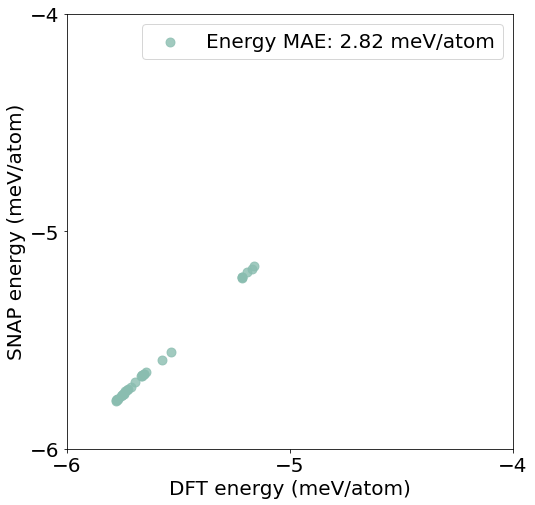

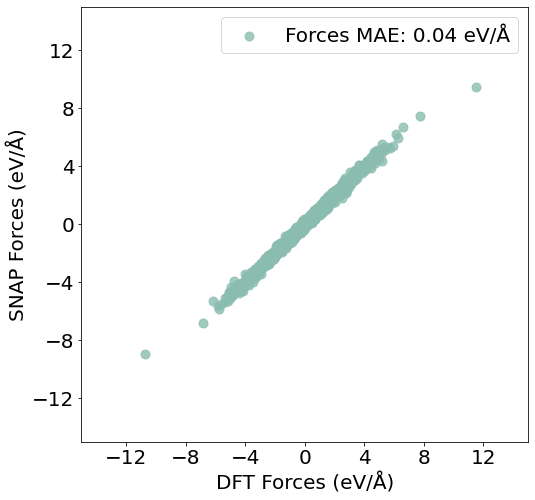

In [26]:
energy_indices = np.argwhere(np.array(df_orig["dtype"]) == "energy").ravel()
forces_indices = np.argwhere(np.array(df_orig["dtype"]) == "force").ravel()
orig = df_orig['y_orig']/df_orig['n']
predict = df_predict['y_orig']/df_orig['n']

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(orig[energy_indices], predict[energy_indices], color='#8ABDB0', s=80, alpha=0.8, 
            label="Energy MAE: {:.2f} meV/atom".format(mean_absolute_error(orig[energy_indices], predict[energy_indices]) * 1000))
ax1.set_xlim(-6, -4)
ax1.set_ylim(-6, -4)
ax1.set_xlabel("DFT energy (meV/atom)", fontsize=20)
ax1.set_ylabel("SNAP energy (meV/atom)", fontsize=20)
ax1.legend(fontsize=20)

from matplotlib import ticker

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))

fig, ax2 = plt.subplots(figsize=(8, 8))
ax2.scatter(orig[forces_indices], predict[forces_indices], color='#8ABDB0', s=80, alpha=0.8,
            label="Forces MAE: {:.2f} eV/Å".format(mean_absolute_error(orig[forces_indices], predict[forces_indices])))
ax2.set_xlim(-15, 15)
ax2.set_ylim(-15, 15)
ax2.set_xlabel("DFT Forces (eV/Å)", fontsize=20)
ax2.set_ylabel("SNAP Forces (eV/Å)", fontsize=20)
ax2.legend(fontsize=20)

ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(4))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(4))

In [25]:
mean_absolute_error(orig[energy_indices], predict[energy_indices]) * 1000

2.8245034530268325

In [24]:
mean_absolute_error(orig[forces_indices], predict[forces_indices])

0.03652407077781436

### 2.3 Predict basic properties

**1. lattice constants prediction** See [LatticeConstants calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

inputs:
 - ff_settings: The potential object. Take SNAPotential as input here.

In [27]:
Ni_cell = Structure.from_spacegroup(sg='Fm-3m', species=['Ni'], lattice=Lattice.cubic(3.51), coords=[[0, 0, 0]])

Ni_lc_calculator = LatticeConstant(Ni_snap)
a, b, c = Ni_lc_calculator.calculate([Ni_cell])[0]
print('Ni', 'Lattice a: {:.3f} Å, Lattice b: {:.3f} Å, Lattice c: {:.3f} Å'.format(a, b, c))

Mo Lattice a: 3.517 Å, Lattice b: 3.517 Å, Lattice c: 3.517 Å


**2. elastic constants prediction** See [ElasticConstants calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

Inputs:
 - ff_settings: The potential object
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.
 - atom_type: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).

In [28]:
Ni_ec_calculator = ElasticConstant(ff_settings=Ni_snap)
Ni_elastic_prop = Ni_ec_calculator.calculate(Ni_train_structures)
print('Ni', ' C11: {:.0f} GPa'.format(Ni_elastic_prop[0][0]), 'C12: {:.0f} GPa'.format(Ni_elastic_prop[0][1]),
      'C44: {:.0f} GPa'.format(Ni_elastic_prop[0][2]), 'Bulk Modulus: {:.0f}'.format(Ni_elastic_prop[0][3]))

Ni  C11: 276 GPa C12: 166 GPa C44: 117 GPa Bulk Modulus: 202


**3. Vacancy formation energy prediction** See [DefectFormation calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

Inputs:
 - ff_settings: The potential object
 - specie: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.

In [29]:
Ni_vacancy_calcualtor = DefectFormation(ff_settings=Ni_snap, specie='Ni', lattice='fcc', alat=3.51)
formation_energy = Ni_vacancy_calcualtor.calculate()
print('Ni Vacancy formation energy: {:.2f} eV'.format(formation_energy))

Ni Vacancy formation energy: 1.28 eV
